In [ ]:
import pandas as pd
import os
import json
from shapely import wkt
from shapely.geometry import Polygon
from geopy.geocoders import Nominatim
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define location of the images and labels
xbd_dir="/content/drive/MyDrive/XBD/train"
images_dir=os.path.join(xbd_dir,"images")
labels_dir=os.path.join(xbd_dir,"labels")
masks_dir = os.path.join(xbd_dir, 'masks')
if not os.path.isdir(masks_dir):
    os.makedirs(masks_dir)
train_data_info=os.path.join(xbd_dir,"small_train_data_info1.csv")
aug_data_dir = os.path.join(xbd_dir, 'aug_data')
if not os.path.isdir(aug_data_dir):
    os.makedirs(aug_data_dir)

# Data Augmentation
for each of the pre_disaster images we create 4 more images and include the same label as pre disaster image and then create a csv file with all the data

In [ ]:
from torchvision import transforms
from PIL import Image

#create a image from the augmentation function.
#after new image is generated, we should have a label for that as well as we should use same coordinates of buildings as in the original image

import cv2
import numpy as np
import matplotlib.pyplot as plt

def contrast_enhancement(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(strength + 1) * image - float(strength) * blurred
    sharpened = np.maximum(sharpened, 0)
    sharpened = np.minimum(sharpened, 255)
    sharpened = sharpened.round().astype(np.uint8)
    return sharpened

def sobel_edge_detection(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)  # x direction
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)  # y direction
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = np.uint8(magnitude)
    return magnitude

def image_augmentation_rgb(image):
    # Split the image into R, G, B channels
    channels = cv2.split(image)

    # Apply contrast enhancement, unsharp masking, and Sobel edge detection to each channel
    augmented_channels = []
    for channel in channels:
        enhanced_channel = contrast_enhancement(channel)
        unsharp_image = unsharp_mask(enhanced_channel)
        edge_image = sobel_edge_detection(unsharp_image)
        augmented_channels.append(edge_image)

    # Merge the augmented channels back into an RGB image
    augmented_image = cv2.merge(augmented_channels)
    return augmented_image


# Load the image
for image_name in os.listdir(images_dir):
  if image_name.endswith(".png") and "_pre" in image_name:
    image_path=os.path.join(images_dir,image_name)
    image = cv2.imread(image_path)

    # Apply image augmentation
    final_image = image_augmentation_rgb(image)
    final_image_name = image_name[:-4] +"_aug"+'.png'
    cv2.imwrite(os.path.join(images_dir,final_image_name),final_image)




In [ ]:
# Dont run if csv file is already created
#Create Dataframe
columns = ['pre_image_name','aug_image_name' ,'post_image_name', 'disaster_name', 'disaster_type',
           'disaster_location', 'num_buildings_pre', 'num_buildings_post',
           'num_no_damage', 'num_minor_damage', 'num_major_damage',
           'num_destroyed', 'num_un_classified','pre_disaster_capture_date','post_disaster_capture_date']
df = pd.DataFrame(columns=columns)
# Fetch values from json labels and enter into dataframe
# Dictionary to fill location for labels with missing buildings
disaster_location_info={}
list_of_missing_files=[]   # it stores the names of files which doesnt have post disaster images
# iterate through all labels files
for json_filename in tqdm(os.listdir(labels_dir)):
    # only process pre disaster json files
    if json_filename.endswith('.json') and "_pre" in json_filename:
        disaster_location=""
        # read json file
        pre_json_filepath=os.path.join(labels_dir,json_filename)
        # set post disaster json file name
        post_json_filepath = os.path.join(labels_dir, json_filename.replace("_pre", "_post"))
        # check if post disaster json file exists and skip considering current json file if post json doesn't exist
        if not os.path.exists(post_json_filepath):
          list_of_missing_files.append(json_filename)
          continue
        # read pre-disaster json
        with open(pre_json_filepath, 'r') as file:
            pre_data = json.load(file)
            # fetch pre-disaster image name from metadata
            pre_image_name=pre_data["metadata"]["img_name"]
            #fetch pre-disaster aug image name
            aug_image_name = pre_image_name[:-4] + "_aug" + '.png'
            # fetch disaster event name from metadata
            disaster_name=pre_data["metadata"]["disaster"]
            # fetch disaster type from metadata
            disaster_type=pre_data["metadata"]["disaster_type"]
            # fetch pre-disaster image capture date from metadata
            pre_disaster_capture_date=datetime.fromisoformat(pre_data["metadata"]["capture_date"][:-1])
            pre_disaster_capture_date=pre_disaster_capture_date.date()
            # fetch lng_lat features from features
            lang_lat_features=pre_data["features"]["lng_lat"]
            # fetch number of buildings from features
            num_buildings_pre=len(pre_data["features"]["lng_lat"])
            # if any buildings exist in the image
            if num_buildings_pre>0:
                # get centroid of the location
                location_coords=lang_lat_features[0]["wkt"]
                centroid =  Polygon(wkt.loads(location_coords)).centroid
                # get location of the centroid
                geolocator = Nominatim(user_agent="geo_locator")
                location = geolocator.reverse((centroid.y, centroid.x))
                # get state/city and country from location
                if 'state' in location.raw['address']:
                    disaster_location = location.raw['address']['state'] + ", " + location.raw['address']['country']
                else:
                    disaster_location = location.raw['address']['city'] + ", " + location.raw['address']['country']
                disaster_location_info[disaster_name] = disaster_location
            # set disaster location to none if there are no buildings in the image
            else:
                disaster_location= None
        # read post-disaster json
        with open(post_json_filepath, 'r') as file:
            post_data = json.load(file)
            # fetch post-disaster image name from metadata
            post_image_name=post_data["metadata"]["img_name"]
            # fetch post-disaster image capture date from metadata
            post_disaster_capture_date=datetime.fromisoformat(post_data["metadata"]["capture_date"][:-1])
            post_disaster_capture_date=post_disaster_capture_date.date()
            # fetch building features from xy features
            building_features=post_data["features"]["xy"]
            # count number of buildings from features
            num_buildings_post=len(building_features)
            # count number of buildings by damage type
            building_damage_info={"no-damage":0,"minor-damage":0,"major-damage":0,"destroyed":0,"un-classified":0}
            for feature in building_features:
                damage_type=feature["properties"]["subtype"]
                building_damage_info[damage_type] += 1
            num_no_damage=building_damage_info["no-damage"]
            num_minor_damage=building_damage_info["minor-damage"]
            num_major_damage=building_damage_info["major-damage"]
            num_destroyed=building_damage_info["destroyed"]
            num_un_classified=building_damage_info["un-classified"]
        # create dataframe row
        row_data = {
            "pre_image_name": pre_image_name,
            "aug_image_name": aug_image_name,
            "post_image_name": post_image_name,
            "disaster_name": disaster_name,
            "disaster_type": disaster_type,
            "disaster_location": disaster_location,
            "num_buildings_pre": num_buildings_pre,
            "num_buildings_post": num_buildings_post,
            "num_no_damage": num_no_damage,
            "num_minor_damage": num_minor_damage,
            "num_major_damage": num_major_damage,
            "num_destroyed": num_destroyed,
            "num_un_classified": num_un_classified,
            "pre_disaster_capture_date": pre_disaster_capture_date,
            "post_disaster_capture_date": post_disaster_capture_date
        }
        # append row to dataframe
        df=pd.concat([df, pd.DataFrame([row_data])], ignore_index=True)

100%|██████████| 396/396 [01:29<00:00,  4.40it/s]


In [ ]:
list_of_missing_files

[]

In [ ]:
#if any disaster location is null fill it with info from disaster_location_info
#run only if csv is not created
df.loc[df["disaster_location"].isnull(), "disaster_location"] = df["disaster_name"].map(disaster_location_info)

In [ ]:
df["pre_disaster_capture_date"][0],df["post_disaster_capture_date"][0]

(datetime.date(2018, 2, 5), datetime.date(2018, 6, 22))

In [ ]:
unique_dates = df.groupby('disaster_name')[['pre_disaster_capture_date', 'post_disaster_capture_date']].agg(pd.Series.unique)
unique_dates

,pre_disaster_capture_date,post_disaster_capture_date
disaster_name,,
guatemala-volcano,[2018-02-05],[2018-06-22]
hurricane-florence,"[2018-08-23, 2018-04-06]","[2018-09-18, 2018-09-20]"
hurricane-harvey,[2017-02-16],[2017-08-31]
hurricane-matthew,[2013-01-05],"[2016-10-01, 2016-10-09]"
hurricane-michael,[2017-11-29],[2018-10-13]
mexico-earthquake,"[2017-01-04, 2017-06-15]",[2017-09-20]
midwest-flooding,[2019-01-26],[2019-05-31]
palu-tsunami,"[2017-01-24, 2017-11-04]",[2018-10-01]
santa-rosa-wildfire,[2017-06-21],[2017-10-11]


In [ ]:
df_capture_dates = df.groupby('disaster_name').agg({'pre_disaster_capture_date': lambda x: x.mode()[0], 'post_disaster_capture_date': lambda x: x.mode()[0]}).reset_index()
df_capture_dates

,disaster_name,pre_disaster_capture_date,post_disaster_capture_date
0,guatemala-volcano,2018-02-05,2018-06-22
1,hurricane-florence,2018-04-06,2018-09-18
2,hurricane-harvey,2017-02-16,2017-08-31
3,hurricane-matthew,2013-01-05,2016-10-09
4,hurricane-michael,2017-11-29,2018-10-13
5,mexico-earthquake,2017-01-04,2017-09-20
6,midwest-flooding,2019-01-26,2019-05-31
7,palu-tsunami,2017-01-24,2018-10-01
8,santa-rosa-wildfire,2017-06-21,2017-10-11
9,socal-fire,2018-10-23,2018-11-14


In [ ]:
# save the dataframe to csv
# run only first time
df.to_csv(train_data_info, index=False)

In [ ]:
# load the csv file if already created
df = pd.read_csv(train_data_info)

In [ ]:
df["post_disaster_capture_date"].value_counts()

post_disaster_capture_date
2017-08-31    20
2018-10-01    20
2018-10-13    20
2017-09-20    20
2017-10-11    20
2018-11-14    20
2019-05-31    20
2018-06-22    18
2016-10-09    11
2018-09-18    10
2018-09-20    10
2016-10-01     9
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   pre_image_name              198 non-null    object
 1   aug_image_name              198 non-null    object
 2   post_image_name             198 non-null    object
 3   disaster_name               198 non-null    object
 4   disaster_type               198 non-null    object
 5   disaster_location           198 non-null    object
 6   num_buildings_pre           198 non-null    int64 
 7   num_buildings_post          198 non-null    int64 
 8   num_no_damage               198 non-null    int64 
 9   num_minor_damage            198 non-null    int64 
 10  num_major_damage            198 non-null    int64 
 11  num_destroyed               198 non-null    int64 
 12  num_un_classified           198 non-null    int64 
 13  pre_disaster_capture_date   198 non-null    object

In [ ]:
# fetch all disaster events in the df
df["disaster_name"].unique()

array(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey',
       'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake',
       'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire',
       'socal-fire'], dtype=object)

In [ ]:
#check if there are any null values
df.isnull().any()

pre_image_name                False
aug_image_name                False
post_image_name               False
disaster_name                 False
disaster_type                 False
disaster_location             False
num_buildings_pre             False
num_buildings_post            False
num_no_damage                 False
num_minor_damage              False
num_major_damage              False
num_destroyed                 False
num_un_classified             False
pre_disaster_capture_date     False
post_disaster_capture_date    False
dtype: bool

In [ ]:
df.head()

,pre_image_name,aug_image_name,post_image_name,disaster_name,disaster_type,disaster_location,num_buildings_pre,num_buildings_post,num_no_damage,num_minor_damage,num_major_damage,num_destroyed,num_un_classified,pre_disaster_capture_date,post_disaster_capture_date
0,guatemala-volcano_00000000_pre_disaster.png,guatemala-volcano_00000000_pre_disaster_aug.png,guatemala-volcano_00000000_post_disaster.png,guatemala-volcano,volcano,"Sacatepéquez, Guatemala",10,10,10,0,0,0,0,2018-02-05,2018-06-22
1,guatemala-volcano_00000007_pre_disaster.png,guatemala-volcano_00000007_pre_disaster_aug.png,guatemala-volcano_00000007_post_disaster.png,guatemala-volcano,volcano,"Sacatepéquez, Guatemala",9,9,9,0,0,0,0,2018-02-05,2018-06-22
2,guatemala-volcano_00000008_pre_disaster.png,guatemala-volcano_00000008_pre_disaster_aug.png,guatemala-volcano_00000008_post_disaster.png,guatemala-volcano,volcano,"Escuintla, Guatemala",0,0,0,0,0,0,0,2018-02-05,2018-06-22
3,guatemala-volcano_00000002_pre_disaster.png,guatemala-volcano_00000002_pre_disaster_aug.png,guatemala-volcano_00000002_post_disaster.png,guatemala-volcano,volcano,"Sacatepéquez, Guatemala",1,1,0,0,0,1,0,2018-02-05,2018-06-22
4,guatemala-volcano_00000006_pre_disaster.png,guatemala-volcano_00000006_pre_disaster_aug.png,guatemala-volcano_00000006_post_disaster.png,guatemala-volcano,volcano,"Escuintla, Guatemala",97,97,97,0,0,0,0,2018-02-05,2018-06-22


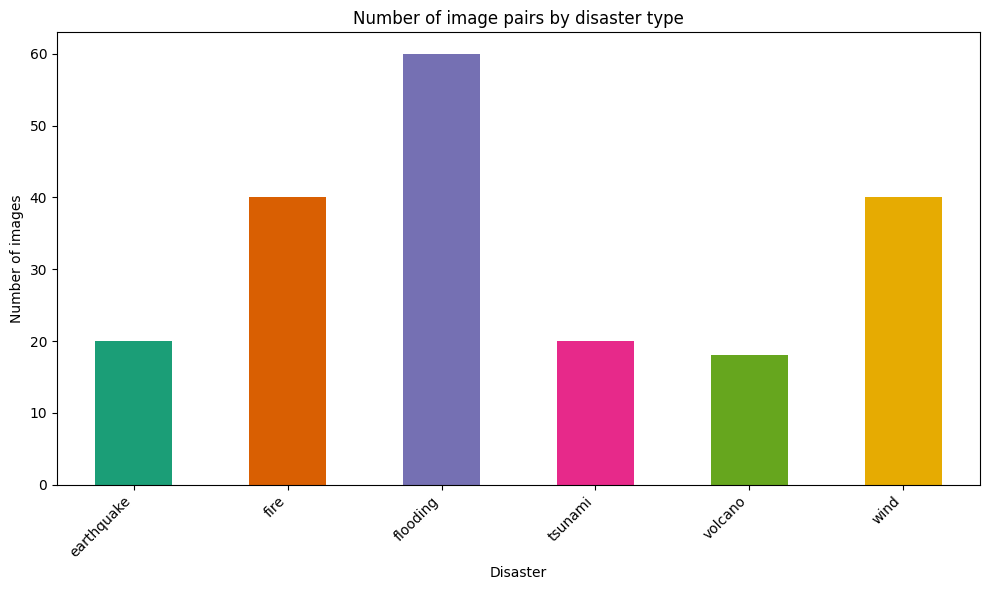

In [ ]:
# plot number of image pairs per disaster type
plt.figure(figsize=(10, 6))
df.groupby('disaster_type').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of image pairs by disaster type')
plt.xlabel('Disaster')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# check if any columns have different number of buildings pre and post disaster
df[df['num_buildings_pre'] != df['num_buildings_post']]

,pre_image_name,aug_image_name,post_image_name,disaster_name,disaster_type,disaster_location,num_buildings_pre,num_buildings_post,num_no_damage,num_minor_damage,num_major_damage,num_destroyed,num_un_classified,pre_disaster_capture_date,post_disaster_capture_date


In [ ]:
# Disaster event name along with disaster location and disaster type
df.groupby('disaster_name')[['disaster_location','disaster_type']].first()

,disaster_location,disaster_type
disaster_name,,
guatemala-volcano,"Sacatepéquez, Guatemala",volcano
hurricane-florence,"South Carolina, United States",flooding
hurricane-harvey,"Texas, United States",flooding
hurricane-matthew,"Département du Sud, Ayiti",wind
hurricane-michael,"Florida, United States",wind
mexico-earthquake,"Ciudad de México, México",earthquake
midwest-flooding,"Arkansas, United States",flooding
palu-tsunami,"Sulawesi Tengah, Indonesia",tsunami
santa-rosa-wildfire,"California, United States",fire


In [ ]:
# Number of image pairs per disaster event
num_images_by_disaster=df["disaster_name"].value_counts()
num_images_by_disaster

disaster_name
hurricane-florence     20
hurricane-harvey       20
midwest-flooding       20
hurricane-matthew      20
hurricane-michael      20
mexico-earthquake      20
santa-rosa-wildfire    20
palu-tsunami           20
socal-fire             20
guatemala-volcano      18
Name: count, dtype: int64

In [ ]:
# number of buildings from all image pairs per disaster event
num_buildings_by_disaster=df.groupby('disaster_name')['num_buildings_pre'].sum()
num_buildings_by_disaster

disaster_name
guatemala-volcano       856
hurricane-florence      867
hurricane-harvey       1467
hurricane-matthew       935
hurricane-michael       683
mexico-earthquake      5803
midwest-flooding       2105
palu-tsunami           3184
santa-rosa-wildfire     831
socal-fire              114
Name: num_buildings_pre, dtype: int64

In [ ]:
# number of images and buildings per disaster event
combined_table = pd.concat([num_images_by_disaster, num_buildings_by_disaster], axis=1)
combined_table.columns = ['Num_Images', 'Num_Buildings']
combined_table

,Num_Images,Num_Buildings
disaster_name,,
hurricane-florence,20,867
hurricane-harvey,20,1467
midwest-flooding,20,2105
hurricane-matthew,20,935
hurricane-michael,20,683
mexico-earthquake,20,5803
santa-rosa-wildfire,20,831
palu-tsunami,20,3184
socal-fire,20,114


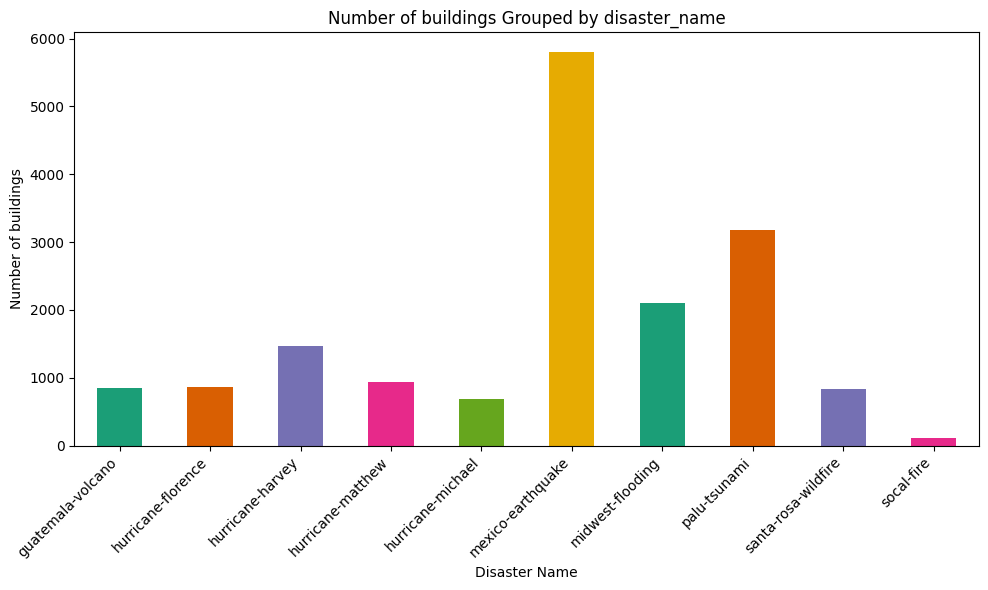

In [ ]:
# plot number of buildings per disaster event
plt.figure(figsize=(10, 6))
num_buildings_by_disaster.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Number of buildings Grouped by disaster_name')
plt.xlabel('Disaster Name')
plt.ylabel('Number of buildings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

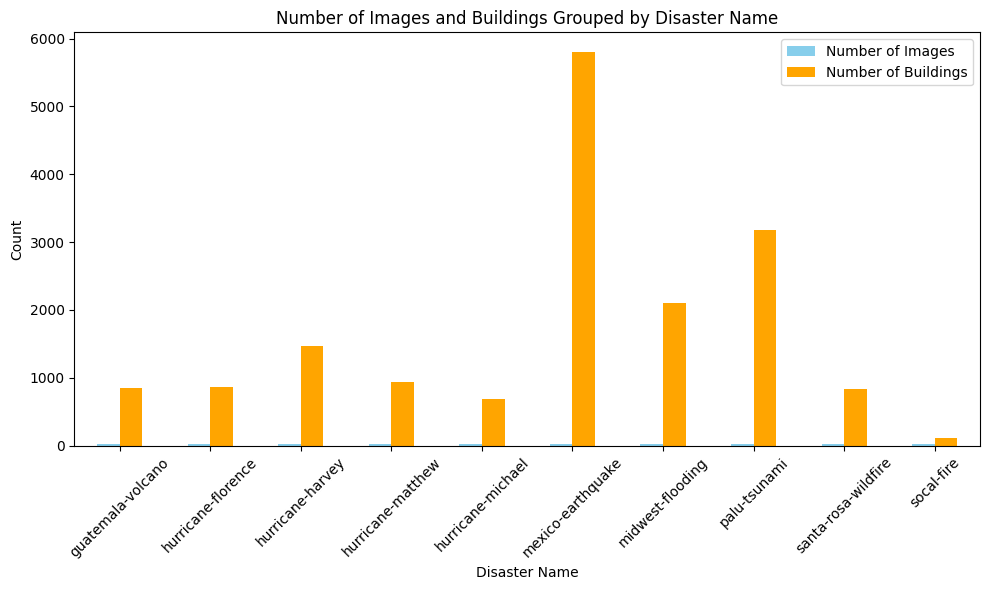

In [ ]:
# plot number of buildings and images comparision
combined_data = pd.DataFrame({"Number of Images": num_images_by_disaster,
                              "Number of Buildings": num_buildings_by_disaster})

ax = combined_data.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
ax.set_title('Number of Images and Buildings Grouped by Disaster Name')
ax.set_xlabel('Disaster Name')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
damage_counts_by_disaster = df.groupby("disaster_name")[["num_no_damage", "num_minor_damage", "num_major_damage", "num_destroyed"]].sum()
damage_counts_by_disaster

,num_no_damage,num_minor_damage,num_major_damage,num_destroyed
disaster_name,,,,
guatemala-volcano,639,9,9,25
hurricane-florence,739,2,48,5
hurricane-harvey,1164,194,86,0
hurricane-matthew,336,471,60,11
hurricane-michael,405,217,23,27
mexico-earthquake,5782,12,0,0
midwest-flooding,1914,23,2,14
palu-tsunami,2298,0,56,546
santa-rosa-wildfire,493,8,11,315


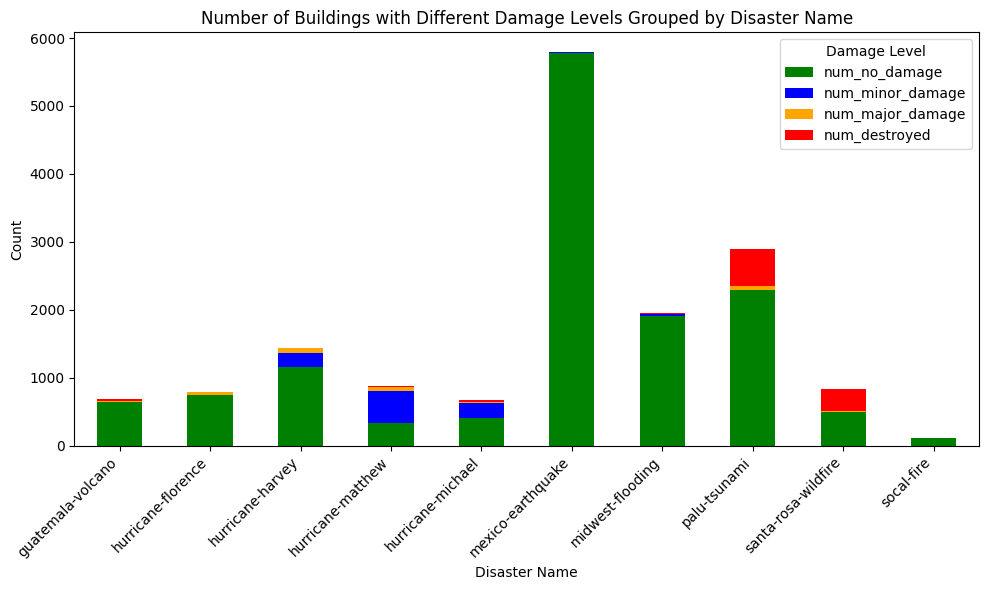

In [ ]:
custom_colors = ['green', 'blue', 'orange', 'red']
damage_counts_by_disaster.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)
plt.title('Number of Buildings with Different Damage Levels Grouped by Disaster Name')
plt.xlabel('Disaster Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Damage Level')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
disaster_names=list(df["disaster_name"].unique())
disaster_names

['guatemala-volcano',
 'hurricane-florence',
 'hurricane-harvey',
 'hurricane-matthew',
 'hurricane-michael',
 'mexico-earthquake',
 'midwest-flooding',
 'palu-tsunami',
 'santa-rosa-wildfire',
 'socal-fire']

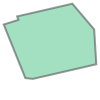

In [ ]:
temp1=wkt.loads("POLYGON ((-79.03585510827186 33.60387497715141, -79.03582104187559 33.60388575665863, -79.03582375650119 33.60389388588764, -79.03569553047664 33.60392338512618, -79.03564470548032 33.60386354920797, -79.03563977720466 33.6037826097889, -79.03578743284996 33.6037485675312, -79.03580478400323 33.60375046033562, -79.03585510827186 33.60387497715141))")
temp1

In [ ]:
import numpy as np
from shapely.geometry import Point, Polygon, mapping
temp2 = list(mapping(temp1)['coordinates'][0])
temp3 = np.array(temp2, np.int32)
temp2,temp3

([(-79.03585510827186, 33.60387497715141),
  (-79.0358210418756, 33.60388575665863),
  (-79.03582375650119, 33.60389388588764),
  (-79.03569553047664, 33.60392338512618),
  (-79.03564470548032, 33.60386354920797),
  (-79.03563977720466, 33.6037826097889),
  (-79.03578743284996, 33.6037485675312),
  (-79.03580478400323, 33.60375046033562),
  (-79.03585510827186, 33.60387497715141)],
 array([[-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33],
        [-79,  33]], dtype=int32))

In [ ]:
import cv2
import numpy as np
from shapely import wkt
from shapely.geometry import mapping, Polygon
import os
import json
from tqdm import tqdm

# Create the Polygon Mask files using the labels
# takes mask size (height and width) and polygon vertices
def generate_polygon_masks(mask_size, polys):
    # shrink the polygon vertices by 2 pixels
    shrink = 2
    # initialize mask array and fill with 0
    mask = np.zeros(mask_size, np.uint8)
    # iterate over all building polygons in the image
    for i in polys:
        # get the polygon vertices
        poly = polys[i]
        # create shapely polygon object for the building
        polygon = Polygon(poly)
        # calculate centroid of the polygon
        (centroid_x, centroid_y) = polygon.centroid.coords[0]
        shrunk_polygon = []
        # iterate over the exterior coordinates
        for (x, y) in polygon.exterior.coords:
            # shrink the polygon by 2 pixels on all sides
            x += shrink if x < centroid_x else -shrink if x > centroid_x else 0
            y += shrink if y < centroid_y else -shrink if y > centroid_y else 0
            shrunk_polygon.append([x, y])
        temp = np.zeros(mask_size, np.uint8)
        # fill the polygon area with white color
        cv2.fillPoly(temp, [np.array(shrunk_polygon, np.int32)], (1, 1, 1))
        mask += temp
    # convert the mask to binary where white pixels represent the polygon areas.
    mask[mask > 1] = 0
    mask[mask == 1] = 255
    return mask



In [ ]:
pre_image_names = []
# Create the full path to the images, labels, and mask output directories
print(f"Starting Mask Generation")
print(f"Source Image Directory: {images_dir} \nSource JSON Directory: {labels_dir}\nOutput Directory: {masks_dir}")

# Get the list of pre-disaster json files
labels_pre = [file_name for file_name in os.listdir(labels_dir) if '_pre' in file_name]

img_count = 0
label_count = 0
mask_count = 0
images_without_buildings_count = 0
missing_files=[]

# generate masks using pre disaster labels
for label_file in tqdm(labels_pre, desc="Generating masks"):
    # Configure source image and generated mask names and paths
    image_name = os.path.splitext(label_file)[0] + '.png'
    pre_image_names.append(image_name)
    if image_name in pre_image_names:
      image_name = os.path.splitext(label_file)[0] + '_aug' + '.png'
      pre_image_names.append(image_name)
    mask_file_name = image_name
    label_full_path = os.path.join(labels_dir, label_file)

    try:
        # Read Data From label JSON file
        with open(label_full_path) as f:
            mask_json = json.load(f)
        label_count += 1
    except Exception as e:
        print(f"Error reading {label_full_path}: {e}")
        continue

    image_file = os.path.join(images_dir, image_name)
    try:
        img = cv2.imread(image_file)
        if img is None:
            raise ValueError(f"Image file {image_file} could not be read.")
        img = np.array(img)
    except Exception as e:
        print(f"Error reading {image_file}: {e}")
        continue

    # mask size is same as image size
    mask_size = img.shape
    img_count += 1

    # Read Building Features from Json
    polys = {}
    for feature in mask_json['features']['xy']:
        # extract building shape in wkt format from json and convert to shapely object
        building_shape = wkt.loads(feature['wkt'])
        # extract building vertices/co-ordinates from shapely object
        coords = list(mapping(building_shape)['coordinates'][0])
        # store co-ordinates to polys dictionary with building id as key
        polys[feature['properties']['uid']] = (np.array(coords, np.int32))

    # generate mask using polygon vertices
    masked_polys = generate_polygon_masks(mask_size, polys)
    # configure mask file path
    mask_file_path = os.path.join(masks_dir, mask_file_name)
    # check if there are any buildings in the image
    if len(polys) >= 0:
        # generate mask using polygon vertices
        #masked_polys = generate_polygon_masks(mask_size, polys)
        # configure mask file path
        #mask_file_path = os.path.join(masks_dir, mask_file_name)
        try:
            # save mask image
            cv2.imwrite(mask_file_path, masked_polys)
            mask_count += 1
        except Exception as e:
            print(f"Error writing mask {mask_file_path}: {e}")
            missing_files.append(mask_file_path)
    else:
      # Save an empty mask for images without buildings
      try:
          cv2.imwrite(mask_file_path, np.zeros(mask_size, np.uint8))
          images_without_buildings_count += 1
      except Exception as e:
          print(f"Error writing empty mask {mask_file_path}: {e}")
          missing_files.append(mask_file_path)

print("Images checked: ", img_count)
print("Labels checked: ", label_count)
print("Masks Generated: ", mask_count)
print("Images Without Buildings: ", images_without_buildings_count)
print("Mask Generation Complete")


Starting Mask Generation
Source Image Directory: /content/drive/MyDrive/XBD/train/images 
Source JSON Directory: /content/drive/MyDrive/XBD/train/labels
Output Directory: /content/drive/MyDrive/XBD/train/masks


Generating masks: 100%|██████████| 198/198 [00:30<00:00,  6.41it/s]

Images checked:  198
Labels checked:  198
Masks Generated:  198
Images Without Buildings:  0
Mask Generation Complete


In [ ]:
from sklearn.model_selection import train_test_split
#Split data into train and test
mask_image_names=os.listdir(masks_dir)
train_set, test_set = train_test_split(pre_image_names, test_size=0.25, random_state=42)
# save train image names to train.txt and test to test.txt
train_file_path=os.path.join(xbd_dir,"train.txt")
test_file_path=os.path.join(xbd_dir,"test.txt")

# Write the train set to train.txt
with open(train_file_path, "w") as train_file:
    train_file.write("\n".join(train_set))

# Write the test set to test.txt
with open(test_file_path, "w") as test_file:
    test_file.write("\n".join(test_set))

In [ ]:
from PIL import Image
# Generate mean.npy for Localization Model
mean_file=os.path.join(xbd_dir,"mean.npy")

N = len(pre_image_names)
sum_color = np.zeros((3,))

# Compute mean image
for i, image_name in enumerate(mask_image_names):
    with Image.open(os.path.join(images_dir, image_name)) as image_file:
        image = np.asarray(image_file, dtype=np.float64)
    sum_color += np.mean(image, axis=(0, 1))

mean = sum_color / N

# Save mean in npy format
np.save(mean_file, mean)